<img src="https://pages.cnpem.br/workshopbioimagens/wp-content/uploads/sites/166/2023/06/logo-ilum-2048x382.png" alt="Descrição da imagem" style="width: 1000px; height: auto; ">

<div style=" padding: 10px; font-size: 34px; text-align: center;">
<strong>A Fera Mascarada</strong> 


<div style=" padding: 10px; font-size: 17px; text-align: center;">
<strong>Autor:</strong> Ana Luz Pereira Mendes, Ana Luiza Poletto Loss
<div style=" padding: 10px; font-size: 17px; text-align: center;">
<strong>Professor:</strong> Daniel R. Cassar

# 4.3 Derrube pra fora
**Objetivo:** Implemente o regularizador dropout na rede neural feita em Python puro.

**Comentário:** Algumas tarefas vão apresentar palavras e conceitos que ainda não vimos em sala. Parte do desafio é justamente se informar sobre estes conceitos.

**Comentário 2:** Observe que o enunciado diz claramente que é para realizar a tarefa na rede neural feita em Python puro nos vídeos da disciplina. Se você está usando o PyTorch, numpy, tensorflow, keras, lightning ou qualquer outra biblioteca pronta, você está no caminho errado!

--------

Neste notebook buscamos entender e implementar o regularizador *Dropout* em *python* puro. O código foi baseado no notebook **ATP-303 NN 4.2 - Notebook MLP** do professor Daniel Roberto Cassar, com as devidas alterações para esta fera formidável.

# INTRODUÇÃO

O regularizador [*Dropout*](https://pt.d2l.ai/chapter_multilayer-perceptrons/dropout.html#:~:text=A%20ideia%20deles%2C%20chamada%20dropout,alguns%20neurônios%20durante%20o%20treinamento.) é uma técnica de regularização usada em redes neurais para prevenir *overfitting*. Durante o treinamento alguns neurônios são "desligados" temporariamente e de forma aleatória ou seja, suas ativações são temporariamente ignoradas em uma determinada iteração. Podemos vizualizar essa intereação na imagem abaixo.

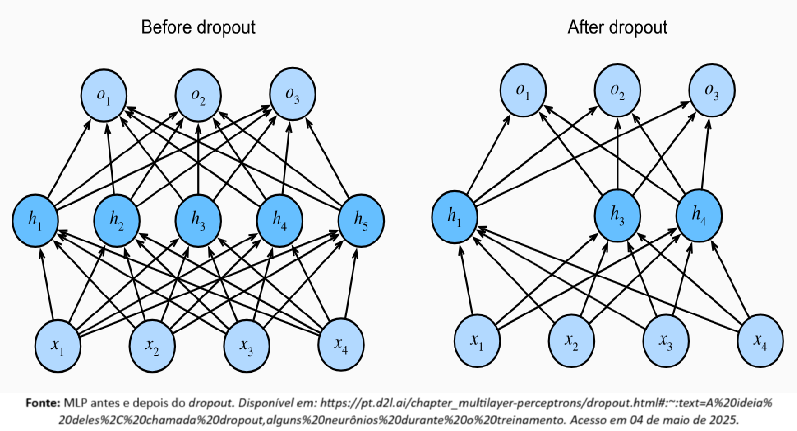

Mas por que isso funciona tão bem?

Porque ao desligar aleatoriamente diferentes conjuntos de neurônios a cada iteração, o modelo é forçado a não depender excessivamente de nenhum caminho ou combinação específica de neurônios. Na prática, isso simula o treinamento de várias redes neurais diferentes com pesos compartilhados.

Como resultado, o modelo tende a aprender representações mais robustas e generalizáveis, reduzindo significativamente o risco de *overfitting*.


Primeiro chamamos as bibliotecas que vamos utilizar nesse notebook.

In [ ]:
import random
import numpy as np
import math

**Definição das classes**:

Como estamos trabalhando com *python* puro precisamos definir algumas objetos fundamentais, como a classe ```Valor```. Esta classe implementa um valor numérico com capacidade de cálculo automático de gradientes, que é fundamental para implementações de redes neurais e algoritmos de aprendizado de máquina.

In [ ]:
class Valor:

# Inicializa um novo valor
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor   # Tupla com os valores que originaram este valor
        self.operador_mae = operador_mae  # String que indica qual operação gerou este valor
        self.rotulo = rotulo  # Rótulo opcional para identificação
        self.grad = 0  # Gradiente (derivada) acumulado para este valor

# Representação string do objeto, mostrando apenas o valor data para facilitar a visualização.
    def __repr__(self):
        return f"Valor(data={self.data})"

# A partir daqui vão começar as operações matemáticas
    def __add__(self, outro_valor):
        """Realiza a operação: self + outro_valor."""

        if not isinstance(outro_valor, Valor): # isinstance é uma função que verifica se um objeto é uma instância de uma determinada classe ou de uma tupla de classes, retornando True ou False.
            outro_valor = Valor(outro_valor)

        progenitor = (self, outro_valor)
        data = self.data + outro_valor.data
        operador_mae = "+"
        resultado = Valor(data, progenitor, operador_mae)

        def propagar_adicao():
            self.grad += resultado.grad
            outro_valor.grad += resultado.grad

        resultado.propagar = propagar_adicao # propagar_adicao que distribui o gradiente igualmente para os progenitores

        return resultado

    def __mul__(self, outro_valor):
        """Realiza a operação: self * outro_valor."""

        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)

        progenitor = (self, outro_valor)
        data = self.data * outro_valor.data
        operador_mae = "*"
        resultado = Valor(data, progenitor, operador_mae)

        def propagar_multiplicacao():
            self.grad += resultado.grad * outro_valor.data # grad_filho * derivada filho em relação a mãe
            outro_valor.grad += resultado.grad * self.data

        resultado.propagar = propagar_multiplicacao # propagar_mutiplicacao aplica a regra da cadeia para multiplicação

        return resultado

    def exp(self):
        """Realiza a operação: exp(self)"""
        progenitor = (self, )
        data = math.exp(self.data)
        operador_mae = "exp"
        resultado = Valor(data, progenitor, operador_mae)

        def propagar_exp():
            self.grad += resultado.grad * data

        resultado.propagar = propagar_exp # propagar_exp aplica a derivada da exponencial

        return resultado

    def __pow__(self, expoente):  # potenciação
        """Realiza a operação: self ** expoente"""
        assert isinstance(expoente, (int, float))
        progenitor = (self, )
        data = self.data ** expoente
        operador_mae = f"**{expoente}"
        resultado = Valor(data, progenitor, operador_mae)

        def propagar_pow():
            self.grad += resultado.grad * (expoente * self.data ** (expoente - 1))

        resultado.propagar = propagar_pow # propagar_pow aplica a regra da potência na derivada

        return resultado

    def __truediv__(self, outro_valor):  #divisão, a/b implementada como a * b^-1
        """Realiza a operação: self / outro_valor"""
        return self * outro_valor ** (-1)

    def __neg__(self): # negação (-a implementada como a * -1)
        """Realiza a operação: -self"""
        return self * -1

    def __sub__(self, outro_valor): # subtração (a - b implementada como a + (-b))
        """Realiza a operação: self - outro_valor"""
        return self + (-outro_valor)

    def __radd__(self, outro_valor): # Versões refletidas para operações com valores não-Valor à esquerda
        """Realiza a operação: outro_valor + self"""
        return self + outro_valor

    def __rmul__(self, outro_valor): # Versões refletidas para operações com valores não-Valor à esquerda
        """Realiza a operação: outro_valor * self"""
        return self * outro_valor

    def sig(self): # Calcula a função sigmóide
        """Realiza a operação: exp(self) / (exp(self) + 1)"""
        return self.exp() / (self.exp() + 1)

    def propagar(self): # Método vazio padrão (substituído por funções específicas em cada operação)
        pass

    def propagar_tudo(self): # Realiza o backpropagation

        self.grad = 1

        ordem_topologica = [] # Cada valor aparece depois de todos os seus progenitores e garante que quando propagamos os gradientes, já temos todos os gradientes necessários calculados.

        visitados = set()

        def constroi_ordem_topologica(v): # Responsável por construir uma ordenação topológica dos cálculos no grafo computacional
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)

        for vertice in reversed(ordem_topologica):# reversed, iterador reverso de uma sequência
            vertice.propagar()

Esta classe implementa um neurônio artificial, que é a unidade fundamental de uma rede neural.

In [ ]:
class Neuronio:

# Inicializa o neurônio com pesos e viés aleatórios

    def __init__(self, num_dados_entrada): # num_dados_entrada, número de entradas que o neurônio receberá
        self.vies = Valor(random.uniform(-1, 1))  # Valor de viés inicializado aleatoriamente entre -1 e 1

        self.pesos = [] # Lista de pesos
        for i in range(num_dados_entrada):
            self.pesos.append(Valor(random.uniform(-1, 1)))

#Calcula a saída do neurônio para uma dada entrada

    def __call__(self, x): # x, lista de valores de entrada (deve ter o mesmo tamanho que self.pesos)

        assert len(x) == len(self.pesos) # O assert é uma declaração de afirmação usada para verificar se uma condição é verdadeira durante a execução do programa. Se a condição for falsa, o Python levantará uma exceção AssertionError.

        soma = 0
        for info_entrada, peso_interno in zip(x, self.pesos):
            soma += info_entrada * peso_interno

        soma += self.vies
        dado_de_saida = soma.sig()

        return dado_de_saida  # Retorna o valor de saída (entre 0 e 1)

# Retorna todos os parâmetros treináveis do neurônios
    def parametros(self):
        return self.pesos + [self.vies]

Esta classe implementa uma camada de uma rede neural, contendo múltiplos neurônios e funcionalidade de *dropout*.

In [ ]:
class Camada:
    def __init__(self, num_neuronios, num_dados_entrada,dropout_rate=0.0, treinando=True):
        neuronios = []

        for _ in range(num_neuronios): # num_neuronios, quantidade de neurônios na camada
            neuronio = Neuronio(num_dados_entrada) #num_dados_entrada, número de entradas para cada neurônio
            neuronios.append(neuronio)

        self.neuronios = neuronios

        self.dropout_rate = dropout_rate # dropout_rate, probabilidade de desativar um neurônio durante o treinamento (0.0 a 1.0)
        self.treinando = treinando # treinando, indica se está em modo de treinamento
        self.mascara = None # mascara, armazena quais neurônios foram desativados pelo dropout

    def __call__(self, x): # foward pass
        dados_de_saida = []

        for neuronio in self.neuronios:
            informacao = neuronio(x)
            dados_de_saida.append(informacao)

        if self.treinando and self.dropout_rate > 0:

          self.mascara = [(random.random() > self.dropout_rate) for _ in dados_de_saida]
          dados_de_saida = [
              saida * (1.0 / (1.0 - self.dropout_rate)) if m else Valor(0.0)
              for saida, m in zip(dados_de_saida, self.mascara)
            ]

        if len(dados_de_saida) == 1:
          return dados_de_saida[0]
        else:
          return dados_de_saida

    def parametros(self): #Retorna lista plana com todos os parâmetros treináveis, pesos e viéses.
        params = []

        for neuronio in self.neuronios:
            params_neuronio = neuronio.parametros()
            params.extend(params_neuronio)

        return params

Esta classe implementa uma rede neural *Multi-Layer Perceptron* ou MLP, que é um tipo fundamental de arquitetura de rede neural artificial.

In [ ]:
class MLP:
    def __init__(self, num_dados_entrada, num_neuronios_por_camada,treinando=True, dropoutrate = 0): # num_dados_entrada, número de features/variáveis de entrada
                                                                                    # num_neuronios_por_camada, lista com o número de neurônios para cada camada oculta
        percurso = [num_dados_entrada] + num_neuronios_por_camada

        camadas = []

        self.treinando = treinando

        for i in range(len(num_neuronios_por_camada)):
            camada = Camada(num_neuronios_por_camada[i], percurso[i],treinando= self.treinando,dropout_rate = dropoutrate)
            camadas.append(camada)

        self.camadas = camadas


    def __call__(self, x):
        for camada in self.camadas:
            x = camada(x)
        return x

    def parametros(self):
        params = []

        for camada in self.camadas:
            parametros_camada = camada.parametros()
            params.extend(parametros_camada)

        return params

**Preparação de dados**:

Nessa amostra temos a nossa ```feature``` "x" com quatro amostras. Em seguida temos o nosso rótulo verdadeiro ```y_true``` que correspondem a cada amostra. Em seguida, configuramos a nossa rede com a quantidade de entrada que queríamos, o número de saídas, quantidade de camadas ocultas e como queremos que fique a arquitetura final de saída da nossa rede. Por fim, a rede neural MLP é criado em ```minha_mlp```.

In [ ]:
x = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

y_true = [1, 0, 0.2, 0.5]

NUM_DADOS_DE_ENTRADA = 3
NUM_DADOS_DE_SAIDA = 1
CAMADAS_OCULTAS = [3, 2]
DROPOUT_RATE =  0.1

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]

minha_mlp = MLP(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede,dropoutrate = DROPOUT_RATE)

**Processo de treinamento**:

Este código implementa o processo completo de treinamento da rede neural MLP, incluindo *forward pass*, cálculo de perda, `backpropagation` e atualização dos pesos. O valor da *loss* deve diminuir ao longo das épocas se o treinamento estiver funcionando corretamente.

NUM_EPOCAS: Número de vezes que o algoritmo verá todo o conjunto de dados.

TAXA_DE_APRENDIZADO: Controla o tamanho do passo na atualização dos pesos.

In [ ]:
NUM_EPOCAS = 500
TAXA_DE_APRENDIZADO = 0.5

minha_mlp.treinando = True # Ativa comportamentos específicos para treino, como dropout.

for epoca in range(NUM_EPOCAS): # Loop de treinamento

    y_pred = []    # forward pass
    for exemplo in x:
        previsao = minha_mlp(exemplo)
        y_pred.append(previsao)

    erros = [] #cálculo de perda
    for yt, yp in zip(y_true, y_pred):
        residuo = yp - yt
        erro_quadratico = residuo ** 2
        erros.append(erro_quadratico)
    loss = sum(erros)

    for p in minha_mlp.parametros():   # zerar o gradientes
        p.grad = 0

    loss.propagar_tudo()   # backpropagation

    for p in minha_mlp.parametros():  # atualiza parâmetros
        p.data = p.data - p.grad * TAXA_DE_APRENDIZADO

#Monitoramento do Treinamento

    print(epoca, loss.data)

    if epoca % 10 == 0:
        print(f"Época {epoca}, perda: {loss.data:.4f}")
        print(f"Máscara da primeira camada: {minha_mlp.camadas[0].mascara}")

0 1.0233682988338815
Época 0, perda: 1.0234
Máscara da primeira camada: [False, True, True]
1 0.803635619479839
2 0.5608977158106612
3 0.5569283638790388
4 0.3682472666004888
5 0.5827734243445398
6 0.5555883395917816
7 0.5554907947624657
8 0.5577527618939564
9 0.5170149524137686
10 0.544841930037102
Época 10, perda: 0.5448
Máscara da primeira camada: [True, True, True]
11 0.4953824146162669
12 0.7948382518949977
13 0.5549372243544081
14 0.5458556983594565
15 0.5569843517785701
16 0.5506434549079662
17 0.5485112784170396
18 0.6003652253304896
19 0.5595979744952149
20 0.5333390760885093
Época 20, perda: 0.5333
Máscara da primeira camada: [True, True, True]
21 0.44221165059804923
22 0.5185413728074654
23 0.5550876008850996
24 0.502993862001909
25 0.5908022617453932
26 0.5349174512728491
27 0.6675961412736545
28 0.3828944327730234
29 0.6602134203477712
30 0.5644852007313997
Época 30, perda: 0.5645
Máscara da primeira camada: [True, True, True]
31 0.39685916281657097
32 0.5524348828899376
3

Essa parte controla comportamentos específicos que diferem entre treinamento e inferência (uso da rede após treinada). Enquanto estiver ```True``` os neurônios são "desligados" aleatoriamente, caso seja ```False``` todos os neurônios permanecem ativos.

In [ ]:
minha_mlp.treinando = False

**Treinamento e predição**:

Aqui estão os valores alvos que a rede neural deve aprender a prever as saídas produzidas pela rede neural para as entradas correspondentes.



In [ ]:
y_true

[1, 0, 0.2, 0.5]

In [ ]:
y_pred

[Valor(data=0.8344675812113249),
 Valor(data=0.06577276821348223),
 Valor(data=0.19433857078659006),
 Valor(data=0.0)]

Os valores da predição estão bem próximos dos valores verdadeiros, o que significa que parece que a rede parece estar aprendendo a relação entre entradas e saídas.

---------------
#CONCLUSÃO

Essa Fera Formidável proporcionou, principalmente, uma compreensão mais ampla de como uma rede neural funciona e como podemos realizar alterações nela. Entender sobre o ```Dropout```, neste trabalho, permitiu perceber que não é necessário utilizar todos os neurônios de uma rede, mostrando que apenas alguns realmente possuem importância para a predição. Assim, ao observar o ```y_true``` e o ```y_pred```, percebe-se que não houve uma diferença significativa, ou seja, o desligamento aleatório de alguns neurônios durante o treinamento foi importante para aumentar a capacidade de generalização.

---------------
# REFERÊNCIAS

JOVIA. O que é Dropout? Disponível em: https://jovia.com.br/glossario/o-que-e-dropout/. Acesso em: 2 maio 2025.

DEEP LEARNING BOOK. Capítulo 23 – Como funciona o Dropout. Disponível em: https://www.deeplearningbook.com.br/capitulo-23-como-funciona-o-dropout/. Acesso em: 2 maio 2025.

IBM. Regularização: Por que é importante? Disponível em: https://www.ibm.com/br-pt/think/topics/regularization. Acesso em: 2 maio 2025.

DATACAMP. Dropout Regularization Using PyTorch – A Complete Guide. Disponível em: https://www.datacamp.com/pt/tutorial/dropout-regularization-using-pytorch-guide. Acesso em: 2 maio 2025.

OPENAI. Explicação sobre Dropout – Compartilhamento do ChatGPT. Disponível em: https://chatgpt.com/share/6816210b-2018-800c-9743-054142af3754. Acesso em: 2 maio 2025.